In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scienceplots
from numba import njit
import tqdm
import time

plt.style.use(['science', 'grid', 'notebook'])

# Ejercicio 2

Simular la dinámica de Hopfield con ruido usando la regla

$$Pr(s_i(t+1) = \pm 1) = \frac{\exp(\pm \beta h_i(t))}{\exp(\beta h_i(t)) + \exp(-\beta h_i(t))} $$


donde $h_i(t) = \sum_{j=1}^{N} w_{ij}s_j(t)$ y $w_{ij} = \frac{1}{N} \sum_{\mu=1}^{p} \xi_i^{\mu} \xi_j^{\mu}$
j=1 wijsj(t). Tomar como condiciónn inicial cada uno de los patrones $x_i^\mu$. Recorrer toda la red aplicando esta regla y despues
de visitar cada sitio 10 veces calcular el overlap. Tomar N = 4000,p=
40 y graficar el overlap medio como funcion de T = 1/β, para T=
0.1,0.2,...,2.

In [6]:
@njit
def generate_patron(p, N):
    """
    Genera una matriz de datos aleatorios con valores -1 y 1 de manera uniforme.
    
    Parámetros:
    N (int): Número de filas.
    p (int): Número de columnas.
    
    Retorna:
    np.ndarray: Matriz de tamaño (N, p) con valores -1 y 1.
    """
    # Generamos una matriz de valores aleatorios -1 y 1
    random_matrix = np.random.randint(0, 2, (p, N)) *2 -1
    return np.ascontiguousarray(random_matrix.astype(np.float64))

@njit
def calculate_connections(data):
    """
    Calcula la matriz de conexiones para una matriz de datos.
    
    Parámetros:
    data (np.ndarray): Matriz de datos.
    
    Retorna:
    np.ndarray: Matriz de conexiones.
    """
    
    N = data.shape[1]
    W = np.zeros((N, N), dtype=np.float64)
    data = data.T  # Transponemos la matriz para que coincida con la forma del bucle
    
    # Solo calculamos la mitad superior de la matriz y reflejamos los valores para optimizar
    for i in range(N):
        for j in range(i + 1, N):
            W[i, j] = np.dot(data[i], data[j]) / N
            W[j, i] = W[i, j]  # Reflejamos para la simetría
    return W

@njit
def probability(beta, h):
    return np.exp(beta*h) / (np.exp(beta*h) + np.exp(-beta*h))

@njit
def actualize(W, s, beta):
    index = np.arange(s.size)
    np.random.shuffle(index)
    s_new = s.copy()
    for i in index:
        h = np.dot(W[i], s)
        p = probability(beta, h)
        s_new[i] = 1 if np.random.rand() < p else -1
    return s_new

@njit
def iterate_dynamic(W, s, beta, n_iter):
    result = np.zeros_like(s)
    for i in range(n_iter):
        result = actualize(W, s, beta)
        s = result
    return result

@njit(parallel=True)
def calculate_overlaps(W, data, betas, n_iter=10):
    overlaps_mean = np.zeros(betas.size)
    overlaps_std = np.zeros(betas.size)

    for i in range(betas.size):
        print("Calculando beta= ", betas[i])
        res = np.zeros(data.shape[0])
        for mu in range(data.shape[0]):
            res[mu] = np.dot(data[mu], iterate_dynamic(W, data[mu], betas[i], n_iter)) / data.shape[1]

        overlaps_mean[i] = res.mean()
        overlaps_std[i] = res.std() / np.sqrt(data.shape[0])

    return overlaps_mean, overlaps_std


In [7]:
N = 4000
p = 40
step = 0.1
T = np.arange(0.1, 2+step, step)
betas = 1/T
n_iter = 10

In [8]:

data = generate_patron(p, N)
W = calculate_connections(data)
overlaps_mean, overlaps_std = calculate_overlaps(W, data, betas, n_iter)

Calculando beta=  10.0
Calculando beta=  5.0
Calculando beta=  3.333333333333333
Calculando beta=  2.5
Calculando beta=  2.0
Calculando beta=  1.6666666666666667
Calculando beta=  1.4285714285714284
Calculando beta=  1.25
Calculando beta=  1.1111111111111112
Calculando beta=  1.0
Calculando beta=  0.9090909090909091
Calculando beta=  0.8333333333333333
Calculando beta=  0.769230769230769
Calculando beta=  0.7142857142857142
Calculando beta=  0.6666666666666665
Calculando beta=  0.625
Calculando beta=  0.588235294117647
Calculando beta=  0.5555555555555555
Calculando beta=  0.5263157894736842
Calculando beta=  0.5


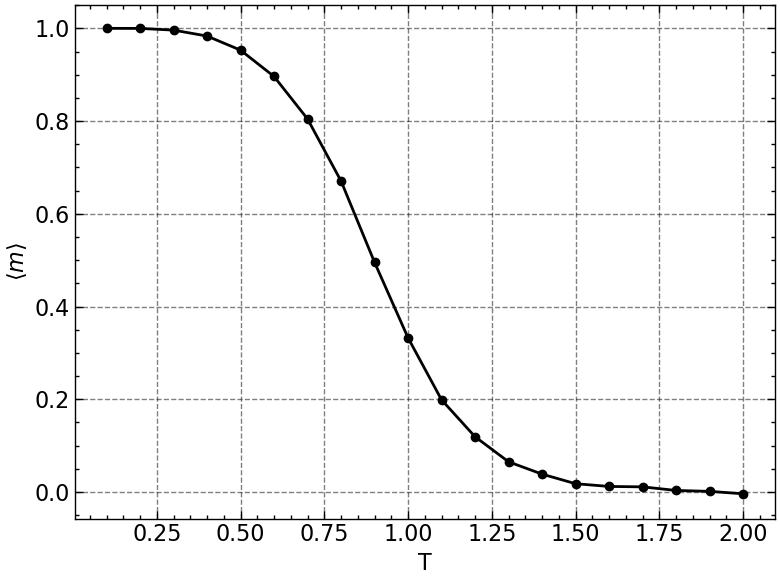

In [16]:
plt.figure(figsize=(8, 6))
plt.errorbar(T, overlaps_mean, yerr=overlaps_std, fmt='o-', label='Simulación', color='black')
plt.xlabel('T')
plt.ylabel(r'$\langle m \rangle$')

plt.tight_layout()
plt.savefig('../doc/figures/overlaps_ej_2.pdf', dpi=500)